In [ ]:
# import os os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pygeos
import numpy as np
import pandas as pd
import momepy
import pyproj
gpd.options.use_pygeos = True

from shapely.errors import ShapelyDeprecationWarning
# warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
# warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [2]:
parcels_path = './data/Charlotte-NC-parcels/mecklenburg-parcels-09-19-2023/'
blocks_path= './data/Charlotte-NC-blocks/'

In [3]:
blocks_set = gpd.read_file(blocks_path).to_crs(3857)
parcels_set = gpd.read_file(parcels_path).to_crs(3857)

In [4]:
# #load geopandas (if required)
brooklyn_path = './data/Charlotte-NC-buildings-clean'
buildings_df = gpd.read_file(brooklyn_path).to_crs(3857)

In [5]:
# remove duplicates in parcels
indexes_to_remove = []
my_dict = {}
for index, row in parcels_set.iterrows():
    if row['geometry'] not in my_dict:
        my_dict[row['geometry']] = 1
    else:
        indexes_to_remove.append(index)
parcels_set = parcels_set.drop(indexes_to_remove)
parcels_set.reset_index(drop=True, inplace=True)
print(f'{len(indexes_to_remove)} duplicate parcels removed from dataset.')

60466 duplicate parcels removed from dataset.


In [6]:
# remove duplicates in blocks
indexes_to_remove = []
my_dict = {}
for index, row in blocks_set.iterrows():
    if row['geometry'] not in my_dict:
        my_dict[row['geometry']] = 1
    else:
        indexes_to_remove.append(index)
blocks_set = blocks_set.drop(indexes_to_remove)
blocks_set.reset_index(drop=True, inplace=True)
print(f'{len(indexes_to_remove)} duplicate blocks removed from dataset.')

0 duplicate blocks removed from dataset.


In [7]:
# remove duplicates in buildings
indexes_to_remove = []
my_dict = {}
for index, row in buildings_df.iterrows():
    if row['geometry'] not in my_dict:
        my_dict[row['geometry']] = 1
    else:
        indexes_to_remove.append(index)
buildings_df = buildings_df.drop(indexes_to_remove)
buildings_df.reset_index(drop=True, inplace=True)
print(f'{len(indexes_to_remove)} duplicate buildings removed from dataset.')

0 duplicate buildings removed from dataset.


In [8]:
parcels_df = parcels_set.copy()
parcels_df['blockID'] = None

In [ ]:
# keep the parcels that correspond to a building
parcels_df = gpd.sjoin(parcels_df, buildings_df, op='intersects')

In [10]:
# add building id
buildings_df['buildingID'] = [i for i in range(len(buildings_df))]

# add parcel id
parcels_df['parcelID'] = [i for i in range(len(parcels_df))]

In [11]:
# Iterate blocks, check building and parcel inclusion
for index, block in blocks_set.iterrows():
  block_geometry = block['geometry']
  block_ID = block['GEOID10']

  buildings_in_block = buildings_df[buildings_df.geometry.within(block_geometry)].index.tolist()
  # print(buildings_in_block)
  if len(buildings_in_block) > 0:
    buildings_df.loc[buildings_in_block,'blockID']= block_ID

In [12]:
for index, parcel in parcels_df.iterrows():
  parcel_geometry = parcel['geometry']
  parcel_ID = parcel['parcelID']

  # split building if in more than 1 parcel
  buildings_in_parcel = buildings_df[buildings_df.geometry.within(parcel_geometry)].index.tolist()

  if len(buildings_in_parcel):
    buildings_df.loc[buildings_in_parcel,'parcelID']= parcel_ID

<Axes: >

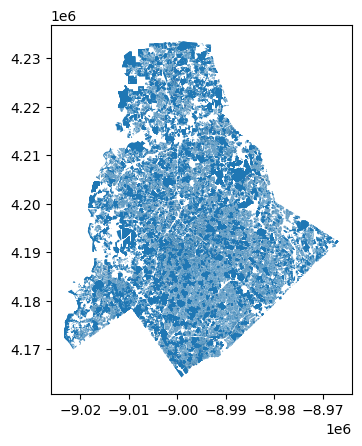

In [13]:
parcels_df.plot()

<Axes: >

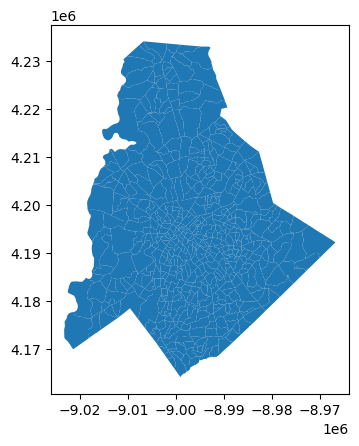

In [14]:
blocks_set.plot()

<Axes: >

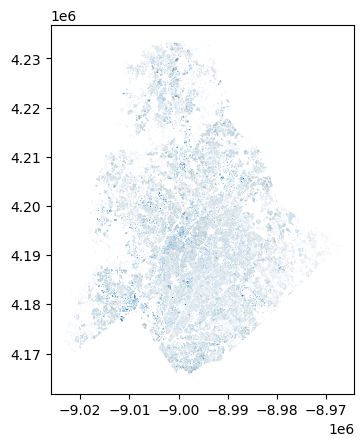

In [15]:
buildings_df.plot()

In [ ]:
bpb = buildings_df.groupby('blockID')

# Get the size of each group
block_sizes = bpb.size()
print(f'Max num of buildings in block: {block_sizes.max()}')
print(f'Average num of buildings in block: {block_sizes.values.mean()}')
print(f'Median num of buildings in block: {np.median(block_sizes.values)}')
print(f'Min num of buildings in block: {np.min(block_sizes.values)}')

# print(block_sizes)
# build_nums = block_sizes.values
# print(build_nums)

#### Charlotte stats:
- Max num of buildings in block: 2080
- Average num of buildings in block: 601.8738738738739
- Median num of buildings in block: 525.0
- Min num of buildings in block: 11

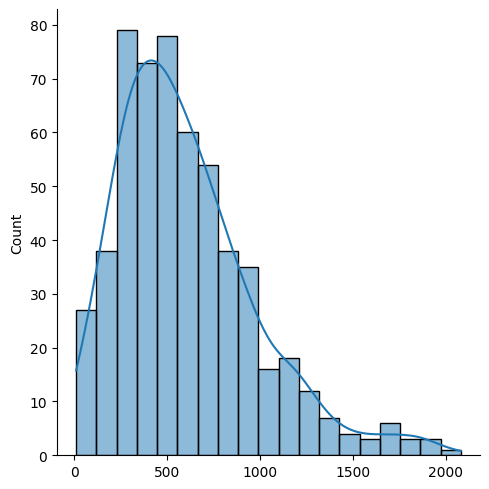

In [20]:
import seaborn as sns
sns.displot(x = block_sizes.values, kde=True)

#### Voronoi Generation

In [21]:
voronoi_data_path = './voronoi_dataset'
baseline_data_path = './baseline_dataset'

In [22]:
blocks_set.reset_index(drop=True, inplace=True)


In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
from matplotlib.lines import Line2D
warnings.filterwarnings("ignore")

In [24]:
columns = ['geometry', 'GEOID10', 'Voronoi_area', 'Baseline_area', 'building_IDs']
voronoi_gdf = gpd.GeoDataFrame(columns = columns)
output_shapefile_path = './voronoi_data'

In [25]:
# remove all buildings that have no parcel id
buildings_df = buildings_df.dropna(subset=['parcelID'])

In [29]:
parcels_df.drop(columns=['index_right'], inplace=True)
parcels_df.reset_index(inplace=True, drop=True)

In [ ]:
#loop buildings
counter = 0
for block_ID in np.sort(blocks_set['GEOID10'].values):
  block = blocks_set[blocks_set['GEOID10']==block_ID]
  parcels_in_block = gpd.sjoin(parcels_df, block, how='inner', op='intersects')
  buildings = buildings_df[buildings_df['blockID']==block_ID]

  if len(buildings)>0:

    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()

    grouped = buildings.groupby('parcelID')
    # Step 2: Apply unary_union to combine geometries within each group
    combined_geoms = grouped['geometry'].apply(lambda x: x.unary_union)
    # Step 3: Create a new GeoDataFrame from the combined geometries
    # Note: combined_geoms is a Series with 'parcel_id' as the index and the combined geometries as values
    grouped_buildings = gpd.GeoDataFrame(combined_geoms, columns=['geometry']).reset_index()
    
    try:
      enclosed_tess = momepy.Tessellation(gdf=grouped_buildings, unique_id='parcelID', enclosures=block, enclosure_id='GEOID10').tessellation
    except:
      continue
    voronoi = pygeos.get_parts(pygeos.from_shapely(enclosed_tess['geometry']))

    building_points = pygeos.multipoints(pygeos.centroid(pygeos.from_shapely(buildings["geometry"])))
    b = pygeos.get_parts(pygeos.voronoi_polygons(geometry=building_points, extend_to=pygeos.from_shapely(block['geometry'])))

    enclosed_net = enclosed_tess['geometry'].boundary.unary_union
    enclosed_net = gpd.GeoDataFrame(geometry=gpd.GeoSeries(enclosed_net)).explode().reset_index(drop=True)

    # Draw plots
    for _, row in parcels_in_block.iterrows():
      gdf = gpd.GeoDataFrame(index=[0], geometry=[row['geometry']])
      if str(row['parcelID']) in buildings['parcelID'].values:
        gdf.plot(ax=ax2, edgecolor = 'white', color = 'lightgray', label = 'built parcel', alpha = 0.3)

    buildings.plot(ax=ax2, edgecolor = 'indigo', color = 'indigo', alpha = 0.6)
    enclosed_tess.plot(ax=ax2, facecolor='none', edgecolor='black')
    block.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth = 2)
    ax2.set_title('Voronoi Parcels')
    # Create custom patches
    voronoi_parcel_patch = Line2D([0], [0], color='black', linewidth=1, label='Voronoi Parcel')
    baseline_parcel_patch = mpatches.Patch(color='lightgray', label='Baseline Parcel', alpha=0.3)

    block_patch = Line2D([0], [0], color='black', linewidth=2, label='Block')
    building_patch = mpatches.Patch(color='indigo', label='Building', alpha=0.6)
    # Add the custom patches to the legend
    ax2.legend(handles=[voronoi_parcel_patch, block_patch, building_patch, baseline_parcel_patch], loc='upper left', bbox_to_anchor=(1, 0.5))
    fig2.savefig(voronoi_data_path+"/voronoi_"+str(buildings['buildingID'].values[0])+"_"+str(buildings['buildingID'].values.shape[0])+".png", bbox_inches='tight')
    # Get the limits after plotting
    x_limits = ax2.get_xlim()
    y_limits = ax2.get_ylim()
    plt.close()

    for _, row in parcels_in_block.iterrows():
      gdf = gpd.GeoDataFrame(index=[0], geometry=[row['geometry']])
      if str(row['parcelID']) in buildings['parcelID'].values:
        gdf.plot(ax=ax1, edgecolor = 'black', color = 'lightblue')
      else:
        gdf.plot(ax=ax1, edgecolor = 'black', color = 'lightgray')

    # parcels_in_block.plot(ax=ax1, edgecolor = 'black', color = 'lightblue')
    buildings.plot(ax=ax1, edgecolor = 'indigo', color = 'indigo', alpha = 0.6)
    ax1.set_title('Baseline Parcels')
    ax1.set_xlim(x_limits)
    ax1.set_ylim(y_limits)
    # Create custom patches
    built_parcel_patch = mpatches.Patch(color='lightblue', label='Parcel')
    other_parcel_patch = mpatches.Patch(color='lightgray', label='Other Parcel')
    building_patch = mpatches.Patch(color='indigo', label='Building', alpha=0.6)
    # Add the custom patches to the legend
    ax1.legend(handles=[built_parcel_patch, other_parcel_patch, building_patch], loc='upper left', bbox_to_anchor=(1, 0.5))
    fig1.savefig(baseline_data_path+"/baseline_"+str(buildings['buildingID'].values[0])+"_"+str(buildings['buildingID'].values.shape[0])+".png", bbox_inches='tight')
    plt.close()
    # drop, find area of cell, and add to global
    enclosed_tess = enclosed_tess[['parcelID', 'geometry', 'GEOID10']]
    enclosed_tess['Voronoi_area'] = enclosed_tess.area
    enclosed_tess['building_IDs'] = np.nan
    # calculate the area of the corresponding parcel
    for index, row in enclosed_tess.iterrows():
      parcel_id = row['parcelID']
      buildings_id_list = buildings[buildings['parcelID']==parcel_id]['buildingID'].values.tolist()
      enclosed_tess.at[index,'building_IDs'] = str(buildings_id_list)
      parcel = parcels_df[parcels_df['parcelID']==int(parcel_id)]
      enclosed_tess.loc[index,'Baseline_area'] = parcel['geometry'].area.values[0]

    voronoi_gdf = pd.concat([voronoi_gdf, enclosed_tess], ignore_index=True) # voronoi_gdf.append(enclosed_tess, ignore_index=True)

    if counter % 100 == 0:
      print('counter', counter)
      voronoi_gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')
      voronoi_gdf['VB_area_diff'] = abs(voronoi_gdf['Baseline_area'] - voronoi_gdf['Voronoi_area'])

    counter += 1
    

voronoi_gdf['VB_area_diff'] = abs(voronoi_gdf['Baseline_area'] - voronoi_gdf['Voronoi_area'])
voronoi_gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')
